# SIR epidemic model - [data assimilation]

This notebook is the second part of inspecting SIR epidemic model. 
Here we will perform epidemic data assimilation with proposed numerical model using manually implemented 4D-Var method in TensorFlow.

## 4D-Var method

Data assimilation is the process of optimizing the fit between gathered data and some prior (theoretical or based on previous measure).

`4D-Var` is one of the methods for data assimilation - it widely used for weather forecast as a successor of `3D-Var` method. 

<img src="https://i.ibb.co/sWLCYSK/Andersson-NL115-figure-1-box-754px.png" width="400">

`4D-Var` loss for $x$ model parameters is defined:

$$J(x) = (x-x_b)^T \boldsymbol{B}^{-1} (x-x_b) + \sum_{i=0}^{n}(y_i-\mathcal{H}_i(x_i))^T \boldsymbol{R}_i^{-1} (y_i-\mathcal{H}_i(x_i))$$

where: 
- $x_b$ - our prior parameters
- $\boldsymbol{B}$ - a background error covariance
- $\boldsymbol{R}$ - a observational error covariance
- $y$ - observation data
- $\mathcal{H}$ - operator that transforms input space vector into output space

`3D-Var` method assumed that all observed data happened at one fixed point of time for given assimilation window. So when performing DA for weather conditions four times a day a six hours  time span is considered as one point in time. As we know weather conditions can change through time so `4D-Var` introduced time dimension to count in temporal changes. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
assert tf.__version__[0] == '2', 'Tensorflow 2.x version required'

In [3]:
np.random.seed(2)
tf.random.set_seed(2)

### Task 1: Complete equations according to formulas

In [4]:
def deriv(y, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Task 2: Complete the formula for each component

In [5]:
def euler(deriv, y0, dt, steps, N, beta, gamma):
    S0, I0, R0 = y0
    S_result, I_result, R_result = S0, I0, R0
    for i in range(steps-1):
        S1, I1, R1 = deriv((S0, I0, R0), N, beta, gamma)
        next_s, next_i, next_r = S0 + dt*S1, I0 + dt*I1, R0 + dt*R1
        S_result = tf.concat([S_result, next_s], axis=0)
        I_result = tf.concat([I_result, next_i], axis=0)
        R_result = tf.concat([R_result, next_r], axis=0)
        S0, I0, R0 = next_s, next_i, next_r
    return S_result, I_result, R_result

In [6]:
# Total population
N = tf.constant([2500.])

# Initial infected and recovered individuals
I0, R0 = tf.constant([1.]), tf.constant([0.])

# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0

# Initial conditions tuple
y0 = S0, I0, R0

# A grid of time points (in days)
days = 160
t = np.linspace(0, days, days)
dt = 1.

In [7]:
prior = tf.constant([[0.3],[0.1]])
trainable_weights = tf.Variable([[0.2],[0.1]]) # posterior
B_inv = tf.eye(2) * 100000.
R_inv = tf.eye(1) * 0.00005

In [8]:
def model_I(deriv, y0, dt, steps, N, beta, gamma):
    _, I, _ = euler(deriv, y0, dt, steps, N, beta, gamma)
    return I[:, None, None]

In [9]:
def model_x(x_pred, horizon=70):
    return model_I(deriv, y0, dt, days, N, x_pred[0,0], x_pred[1,0])[:horizon]

### Loading dataset

In [10]:
data = pd.read_csv('New Zealand COVID active cases.csv', delimiter=';')
data.head()

,Date,Active cases
0,2020-02-28,1
1,2020-02-29,1
2,2020-03-01,1
3,2020-03-02,1
4,2020-03-03,2


In [11]:
raw = model_x(trainable_weights, horizon=days)
y = data.loc[:, 'Active cases'].values
y = y[:, None, None]

### Task 3: Complete the loss function according to the formula

Hint: You should use `tf.transpose` and `tf.reduce_sum`. In `tf.transpose` for observation part notice that first dimension is batch size

`4D-Var` loss for $x$ model parameters is:

$$J(x) = (x-x_b)^T \boldsymbol{B}^{-1} (x-x_b) + \sum_{i=0}^{n}(y_i-\mathcal{H}_i(x_i))^T \boldsymbol{R}_i^{-1} (y_i-\mathcal{H}_i(x_i))$$

With exemplary substitution it would be:

\begin{gather}
J(x) = 
\begin{bmatrix} x_{0} & x_{1} \end{bmatrix} 
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} x_{0} \\ x_{1} \end{bmatrix}
      +
\sum_{i=0}^{n}
\begin{bmatrix} y_{0}^i & y_{1}^i \end{bmatrix} 
\begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\begin{bmatrix} y_{0}^i \\ y_{1}^i \end{bmatrix}
\end{gather}

In [12]:
# (batch_size, rows, cols)
@tf.function
def custom_loss(prior, x_pred):
    custom_loss = tf.transpose(x_pred-prior) @ B_inv @ (x_pred-prior) + \
      tf.reduce_sum(tf.transpose(y-model_x(x_pred),perm=[0,2,1]) @ R_inv @ (y-model_x(x_pred)))
    return custom_loss

In [13]:
opt = tf.optimizers.Adam(learning_rate=0.001)

In [14]:
num_iters = 200
penalty = np.zeros(num_iters, np.float64)

for i in range(num_iters):
    with tf.GradientTape() as tape:
        loss = custom_loss(prior, trainable_weights)
    grads = tape.gradient(loss, trainable_weights)
    opt.apply_gradients([(grads, trainable_weights)])
    penalty[i] = loss
    if i % 10 == 0:
        print(f'Loss for {i}th iteration: ', loss.numpy().squeeze())

Loss for 0th iteration:  1591.4475
Loss for 10th iteration:  1364.8013
Loss for 20th iteration:  1175.9275
Loss for 30th iteration:  1001.5325
Loss for 40th iteration:  839.0573
Loss for 50th iteration:  684.324
Loss for 60th iteration:  541.3607
Loss for 70th iteration:  415.45016
Loss for 80th iteration:  311.19174
Loss for 90th iteration:  229.98332
Loss for 100th iteration:  170.2839
Loss for 110th iteration:  128.70306
Loss for 120th iteration:  101.1546
Loss for 130th iteration:  83.74431
Loss for 140th iteration:  73.22603
Loss for 150th iteration:  67.14407
Loss for 160th iteration:  63.777145
Loss for 170th iteration:  61.99328
Loss for 180th iteration:  61.089775
Loss for 190th iteration:  60.652817


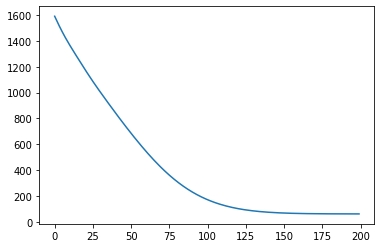

In [15]:
plt.plot(penalty)

In [16]:
tf.transpose(trainable_weights-prior) @ B_inv @ (trainable_weights-prior)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[21.093924]], dtype=float32)>

In [17]:
tf.reduce_sum(tf.transpose(y-model_x(trainable_weights),perm=[0,2,1]) @ R_inv @ (y-model_x(trainable_weights)))

<tf.Tensor: shape=(), dtype=float32, numpy=39.35813>

In [18]:
trainable_weights

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.313344  ],
       [0.09426614]], dtype=float32)>

In [19]:
print(custom_loss.pretty_printed_concrete_signatures())

custom_loss(prior, x_pred)
  Args:
    prior: float32 Tensor, shape=(2, 1)
    x_pred: VariableSpec(shape=(2, 1), dtype=tf.float32, name='x_pred')
  Returns:
    float32 Tensor, shape=(1, 1)


## Plotting

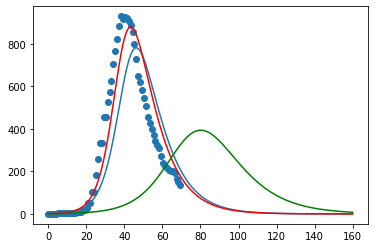

In [20]:
fig, ax = plt.subplots()
ax.plot(t, tf.squeeze(model_x(prior, horizon=days)))
ax.plot(t, tf.squeeze(model_x(trainable_weights, horizon=days)), color='r')
ax.plot(t, tf.squeeze(raw), color='g')
ax.scatter(t[:70], tf.squeeze(y))

### Task 4: What is the number of cases for day no. 80?

### Task 5: Perform epidemic prediction, find params that won't exceed health system capacity

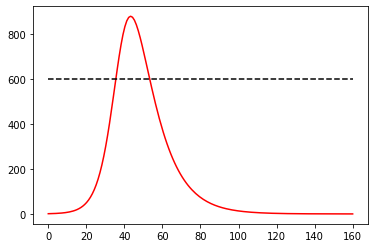

In [21]:
fig, ax = plt.subplots()
health_sys_cap = 600
ax.plot(t, tf.squeeze(model_x(trainable_weights, horizon=days)), color='r')
ax.plot(t, [health_sys_cap for _ in t], '--k')